In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Simulation of a single polarization optical signal transmission

In [2]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 64                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 600000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.11        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
#Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [3]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['text.usetex'] = False

plt.style.use('science')

In [4]:
CSPR = np.arange(3, 16, 0.5)

BER_KK = np.zeros(CSPR.size)
SER_KK = np.zeros(CSPR.size)
GMI_KK = np.zeros(CSPR.size)
MI_KK  = np.zeros(CSPR.size)
SNR_KK = np.zeros(CSPR.size)

for indCSPR, CSPR_ in enumerate(CSPR):

    # generate optical signal signal
    sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # simulate linear signal propagation
    sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

    # receiver detection and demodulation
    Fc = paramTx.Fc
    Ts = 1 / Fs
    mod = QAMModem(m=paramTx.M)

    freqGrid = paramTx.freqGrid
    print(
        "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
        % (
            chIndex,
            (Fc + freqGrid[chIndex]) / 1e12,
            const.c / (Fc + freqGrid[chIndex]) / 1e-9,
        )
    )

    symbTx = symbTx_[:, :, chIndex]

    Plo_dBm = CSPR_
    Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

    print(
        "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
        % (Plo_dBm, lw / 1e3, FO / 1e6)
    )

    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

    # ### Phase-retrieval stage

    # In[4]:

    # resampling to ADC sampling rate
    sigCh = resample(sigCh, paramADC)
    sfm = resample(sfm, paramADC)
    newFs = paramADC.SpS_out*paramTx.Rs

    # simulate ideal direct-detection optical receiver
    Amp = np.abs(sigRx)
    Amp = resample(Amp, paramADC)

    # Kramers-Kronig phase-retrieval
    phiTime = KramersKronigRx(Amp, newFs)

    # optical field reconstruction
    sigRx = Amp*np.exp(1j*phiTime)

    # remove DC level
    sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

    # downshift to baseband
    t = np.arange(0, len(sigRx))*(1/newFs)
    sigRx *= np.exp(-1j * (2 * π * FO * t))

    # correct for (possible) phase ambiguity
    rot = np.mean(sigCh/sigRx)
    sigRx = rot * sigRx
    sigRx = sigRx / np.sqrt(signal_power(sigRx))

    # #### Standard receiver processing

    # In[5]:

    # resample to 2 samples/symbol:
    paramRes = parameters()
    paramRes.Rs = paramTx.Rs
    paramRes.SpS_in = paramADC.SpS_out
    paramRes.SpS_out = 2

    sigRx = resample(sigRx, paramRes)

    # Matched filtering and CD compensation

    # Matched filtering
    if paramTx.pulse == "nrz":
        pulse = pulseShape("nrz", paramADC.SpS_out)
    elif paramTx.pulse == "rrc":
        pulse = pulseShape(
            "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
        )

    pulse = pulse / np.max(np.abs(pulse))
    sigRx = firFilter(pulse, sigRx)

    # plot constellations after matched filtering
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

    # CD compensation
    sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

    #plot constellations after CD compensation
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

    # Downsampling to 2 sps and re-synchronization with transmitted sequences
    sigRx = sigRx.reshape(-1, 1)

    symbRx = symbolSync(sigRx, symbTx, 2)

    # In[6]:

    # Power normalization
    x = sigRx
    d = symbRx

    x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
    d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

    # Adaptive equalization
    mod = QAMModem(m=paramTx.M)

    paramEq = parameters()
    paramEq.nTaps = 15
    paramEq.SpS = 2
    paramEq.mu = [5e-3, 2e-3]
    paramEq.numIter = 5
    paramEq.storeCoeff = False
    paramEq.alg = ["nlms", "dd-lms"]
    paramEq.M = paramTx.M
    paramEq.L = [20000, 80000]

    y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

    discard = int(paramEq.L[0]/2)

    #plot constellations after adaptive equalization
    #pconst(y_EQ[discard:-discard, :], lim=True)

    # In[7]:

    # Carrier phase recovery
    paramCPR = parameters()
    paramCPR.alg = "bps"
    paramCPR.M = paramTx.M
    paramCPR.N = 75
    paramCPR.B = 64
    paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

    y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    discard = 5000

    # plot constellations after CPR
    #pconst(y_CPR[discard:-discard, :], lim=True)

    # #### Evaluate transmission metrics

    # In[8]:

    # correct for (possible) phase ambiguity
    for k in range(y_CPR.shape[1]):
        rot = np.mean(d[:, k] / y_CPR[:, k])
        y_CPR[:, k] = rot * y_CPR[:, k]

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    ind = np.arange(discard, d.shape[0] - discard)
    BER_KK[indCSPR], SER_KK[indCSPR], SNR_KK[indCSPR] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
    GMI_KK[indCSPR], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
    MI_KK[indCSPR] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

    print("Results:\n")
    print("SER: %.2e" % (SER_KK[indCSPR]))
    print("BER: %.2e" % (BER_KK[indCSPR]))
    print("SNR: %.2f dB" % (SNR_KK[indCSPR]))
    print("MI: %.2f bits" % (MI_KK[indCSPR]))
    print("GMI: %.2f bits" % (GMI_KK[indCSPR]))

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 3.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 3.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.100992.
nlms pre-convergence training iteration #1
nlms MSE = 0.083178.
nlms pre-convergence training iteration #2
nlms MSE = 0.082443.
nlms pre-convergence training iteration #3
nlms MSE = 0.082052.
nlms pre-convergence training iteration #4
nlms MSE = 0.081800.


dd-lms - training stage #1
dd-lms MSE = 0.015949.
Results:

SER: 9.81e-01
BER: 4.78e-01
SNR: 0.18 dB
MI: -0.14 bits
GMI: -0.05 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 3.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 3.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.087755.
nlms pre-convergence training iteration #1
nlms MSE = 0.070429.
nlms pre-convergence training iteration #2
nlms MSE = 0.069720.
nlms pre-convergence training iteration #3
nlms MSE = 0.069349.
nlms pre-convergence training iteration #4
nlms MSE = 0.069116.


dd-lms - training stage #1
dd-lms MSE = 0.016013.
Results:

SER: 9.80e-01
BER: 4.76e-01
SNR: 0.23 dB
MI: -0.12 bits
GMI: -0.04 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 4.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 4.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.076286.
nlms pre-convergence training iteration #1
nlms MSE = 0.058856.
nlms pre-convergence training iteration #2
nlms MSE = 0.058186.
nlms pre-convergence training iteration #3
nlms MSE = 0.057834.
nlms pre-convergence training iteration #4
nlms MSE = 0.057612.


dd-lms - training stage #1
dd-lms MSE = 0.016064.
Results:

SER: 9.78e-01
BER: 4.72e-01
SNR: 0.24 dB
MI: -0.10 bits
GMI: -0.04 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 4.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 4.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.067257.
nlms pre-convergence training iteration #1
nlms MSE = 0.049889.
nlms pre-convergence training iteration #2
nlms MSE = 0.049283.
nlms pre-convergence training iteration #3
nlms MSE = 0.048969.
nlms pre-convergence training iteration #4
nlms MSE = 0.048774.


dd-lms - training stage #1
dd-lms MSE = 0.015785.
Results:

SER: 9.72e-01
BER: 4.46e-01
SNR: 0.81 dB
MI: 0.13 bits
GMI: 0.12 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 5.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 5.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.057668.
nlms pre-convergence training iteration #1
nlms MSE = 0.040455.
nlms pre-convergence training iteration #2
nlms MSE = 0.039901.
nlms pre-convergence training iteration #3
nlms MSE = 0.039617.
nlms pre-convergence training iteration #4
nlms MSE = 0.039442.


dd-lms - training stage #1
dd-lms MSE = 0.015047.
Results:

SER: 6.62e-01
BER: 1.73e-01
SNR: 4.89 dB
MI: 1.46 bits
GMI: 1.72 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 5.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 5.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.052616.
nlms pre-convergence training iteration #1
nlms MSE = 0.034892.
nlms pre-convergence training iteration #2
nlms MSE = 0.034355.
nlms pre-convergence training iteration #3
nlms MSE = 0.034087.
nlms pre-convergence training iteration #4
nlms MSE = 0.033925.


dd-lms - training stage #1
dd-lms MSE = 0.014098.
Results:

SER: 9.76e-01
BER: 4.44e-01
SNR: 0.81 dB
MI: 0.14 bits
GMI: 0.11 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 6.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 6.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.045736.
nlms pre-convergence training iteration #1
nlms MSE = 0.027833.
nlms pre-convergence training iteration #2
nlms MSE = 0.027319.
nlms pre-convergence training iteration #3
nlms MSE = 0.027054.
nlms pre-convergence training iteration #4
nlms MSE = 0.026890.


dd-lms - training stage #1
dd-lms MSE = 0.012997.
Results:

SER: 2.26e-01
BER: 4.51e-02
SNR: 15.41 dB
MI: 4.74 bits
GMI: 4.75 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 6.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 6.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.040182.
nlms pre-convergence training iteration #1
nlms MSE = 0.022660.
nlms pre-convergence training iteration #2
nlms MSE = 0.022109.
nlms pre-convergence training iteration #3
nlms MSE = 0.021822.
nlms pre-convergence training iteration #4
nlms MSE = 0.021646.


dd-lms - training stage #1
dd-lms MSE = 0.011641.
Results:

SER: 1.73e-01
BER: 3.38e-02
SNR: 16.52 dB
MI: 5.00 bits
GMI: 5.01 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 7.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 7.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036245.
nlms pre-convergence training iteration #1
nlms MSE = 0.018846.
nlms pre-convergence training iteration #2
nlms MSE = 0.018325.
nlms pre-convergence training iteration #3
nlms MSE = 0.018051.
nlms pre-convergence training iteration #4
nlms MSE = 0.017882.


dd-lms - training stage #1
dd-lms MSE = 0.010202.
Results:

SER: 1.31e-01
BER: 2.49e-02
SNR: 17.53 dB
MI: 5.20 bits
GMI: 5.21 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 7.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 7.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.031827.
nlms pre-convergence training iteration #1
nlms MSE = 0.014722.
nlms pre-convergence training iteration #2
nlms MSE = 0.014218.
nlms pre-convergence training iteration #3
nlms MSE = 0.013955.
nlms pre-convergence training iteration #4
nlms MSE = 0.013793.


dd-lms - training stage #1
dd-lms MSE = 0.008904.
Results:

SER: 9.67e-02
BER: 1.83e-02
SNR: 18.50 dB
MI: 5.34 bits
GMI: 5.35 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 8.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 8.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028854.
nlms pre-convergence training iteration #1
nlms MSE = 0.011625.
nlms pre-convergence training iteration #2
nlms MSE = 0.011162.
nlms pre-convergence training iteration #3
nlms MSE = 0.010918.
nlms pre-convergence training iteration #4
nlms MSE = 0.010769.


dd-lms - training stage #1
dd-lms MSE = 0.007480.
Results:

SER: 6.79e-02
BER: 1.26e-02
SNR: 19.74 dB
MI: 5.51 bits
GMI: 5.51 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 8.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 8.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026480.
nlms pre-convergence training iteration #1
nlms MSE = 0.009350.
nlms pre-convergence training iteration #2
nlms MSE = 0.008865.
nlms pre-convergence training iteration #3
nlms MSE = 0.008612.
nlms pre-convergence training iteration #4
nlms MSE = 0.008458.


dd-lms - training stage #1
dd-lms MSE = 0.006486.
Results:

SER: 4.89e-02
BER: 8.98e-03
SNR: 20.67 dB
MI: 5.61 bits
GMI: 5.61 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 9.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 9.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.025078.
nlms pre-convergence training iteration #1
nlms MSE = 0.007591.
nlms pre-convergence training iteration #2
nlms MSE = 0.007103.
nlms pre-convergence training iteration #3
nlms MSE = 0.006844.
nlms pre-convergence training iteration #4
nlms MSE = 0.006685.


dd-lms - training stage #1
dd-lms MSE = 0.005233.
Results:

SER: 3.15e-02
BER: 5.66e-03
SNR: 21.92 dB
MI: 5.72 bits
GMI: 5.72 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 9.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 9.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024005.
nlms pre-convergence training iteration #1
nlms MSE = 0.006548.
nlms pre-convergence training iteration #2
nlms MSE = 0.006079.
nlms pre-convergence training iteration #3
nlms MSE = 0.005836.
nlms pre-convergence training iteration #4
nlms MSE = 0.005688.


dd-lms - training stage #1
dd-lms MSE = 0.004300.
Results:

SER: 1.95e-02
BER: 3.46e-03
SNR: 22.99 dB
MI: 5.79 bits
GMI: 5.80 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 10.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022487.
nlms pre-convergence training iteration #1
nlms MSE = 0.005185.
nlms pre-convergence training iteration #2
nlms MSE = 0.004700.
nlms pre-convergence training iteration #3
nlms MSE = 0.004442.
nlms pre-convergence training iteration #4
nlms MSE = 0.004284.


dd-lms - training stage #1
dd-lms MSE = 0.003611.
Results:

SER: 1.34e-02
BER: 2.42e-03
SNR: 23.88 dB
MI: 5.83 bits
GMI: 5.83 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 10.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021686.
nlms pre-convergence training iteration #1
nlms MSE = 0.004459.
nlms pre-convergence training iteration #2
nlms MSE = 0.003982.
nlms pre-convergence training iteration #3
nlms MSE = 0.003731.
nlms pre-convergence training iteration #4
nlms MSE = 0.003577.


dd-lms - training stage #1
dd-lms MSE = 0.002966.
Results:

SER: 8.63e-03
BER: 1.53e-03
SNR: 24.85 dB
MI: 5.88 bits
GMI: 5.88 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 11.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 11.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020799.
nlms pre-convergence training iteration #1
nlms MSE = 0.003721.
nlms pre-convergence training iteration #2
nlms MSE = 0.003268.
nlms pre-convergence training iteration #3
nlms MSE = 0.003027.
nlms pre-convergence training iteration #4
nlms MSE = 0.002879.


dd-lms - training stage #1
dd-lms MSE = 0.002391.
Results:

SER: 4.32e-03
BER: 7.44e-04
SNR: 25.98 dB
MI: 5.94 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 11.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 11.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021124.
nlms pre-convergence training iteration #1
nlms MSE = 0.003327.
nlms pre-convergence training iteration #2
nlms MSE = 0.002863.
nlms pre-convergence training iteration #3
nlms MSE = 0.002614.
nlms pre-convergence training iteration #4
nlms MSE = 0.002460.


dd-lms - training stage #1
dd-lms MSE = 0.001999.
Results:

SER: 2.71e-03
BER: 4.65e-04
SNR: 26.84 dB
MI: 5.96 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019932.
nlms pre-convergence training iteration #1
nlms MSE = 0.003052.
nlms pre-convergence training iteration #2
nlms MSE = 0.002593.
nlms pre-convergence training iteration #3
nlms MSE = 0.002348.
nlms pre-convergence training iteration #4
nlms MSE = 0.002196.


dd-lms - training stage #1
dd-lms MSE = 0.001647.
Results:

SER: 1.42e-03
BER: 2.39e-04
SNR: 27.69 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020208.
nlms pre-convergence training iteration #1
nlms MSE = 0.002919.
nlms pre-convergence training iteration #2
nlms MSE = 0.002461.
nlms pre-convergence training iteration #3
nlms MSE = 0.002217.
nlms pre-convergence training iteration #4
nlms MSE = 0.002066.


dd-lms - training stage #1
dd-lms MSE = 0.001336.
Results:

SER: 5.78e-04
BER: 9.63e-05
SNR: 28.57 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 13.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 13.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019722.
nlms pre-convergence training iteration #1
nlms MSE = 0.002451.
nlms pre-convergence training iteration #2
nlms MSE = 0.001979.
nlms pre-convergence training iteration #3
nlms MSE = 0.001729.
nlms pre-convergence training iteration #4
nlms MSE = 0.001574.


dd-lms - training stage #1
dd-lms MSE = 0.001126.
Results:

SER: 3.78e-04
BER: 6.48e-05
SNR: 29.30 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 13.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 13.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020083.
nlms pre-convergence training iteration #1
nlms MSE = 0.002643.
nlms pre-convergence training iteration #2
nlms MSE = 0.002174.
nlms pre-convergence training iteration #3
nlms MSE = 0.001926.
nlms pre-convergence training iteration #4
nlms MSE = 0.001773.


dd-lms - training stage #1
dd-lms MSE = 0.000990.
Results:

SER: 1.56e-04
BER: 2.59e-05
SNR: 30.00 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 14.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 14.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019515.
nlms pre-convergence training iteration #1
nlms MSE = 0.002247.
nlms pre-convergence training iteration #2
nlms MSE = 0.001790.
nlms pre-convergence training iteration #3
nlms MSE = 0.001549.
nlms pre-convergence training iteration #4
nlms MSE = 0.001401.


dd-lms - training stage #1
dd-lms MSE = 0.000815.
Results:

SER: 8.89e-05
BER: 1.48e-05
SNR: 30.64 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 14.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 14.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020014.
nlms pre-convergence training iteration #1
nlms MSE = 0.002343.
nlms pre-convergence training iteration #2
nlms MSE = 0.001873.
nlms pre-convergence training iteration #3
nlms MSE = 0.001626.
nlms pre-convergence training iteration #4
nlms MSE = 0.001475.


dd-lms - training stage #1
dd-lms MSE = 0.000700.
Results:

SER: 2.22e-05
BER: 3.70e-06
SNR: 31.28 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 15.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 15.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019736.
nlms pre-convergence training iteration #1
nlms MSE = 0.002372.
nlms pre-convergence training iteration #2
nlms MSE = 0.001903.
nlms pre-convergence training iteration #3
nlms MSE = 0.001653.
nlms pre-convergence training iteration #4
nlms MSE = 0.001499.


dd-lms - training stage #1
dd-lms MSE = 0.000625.
Results:

SER: 2.22e-05
BER: 3.70e-06
SNR: 31.79 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 15.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 15.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019738.
nlms pre-convergence training iteration #1
nlms MSE = 0.002309.
nlms pre-convergence training iteration #2
nlms MSE = 0.001852.
nlms pre-convergence training iteration #3
nlms MSE = 0.001612.
nlms pre-convergence training iteration #4
nlms MSE = 0.001464.


dd-lms - training stage #1
dd-lms MSE = 0.000548.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.28 dB
MI: 6.00 bits
GMI: 6.00 bits


C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\1057418893.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(BER_KK), '-o', label='KK Algorithm')
C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\1057418893.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(SER_KK), '-o', label='KK Algorithm')


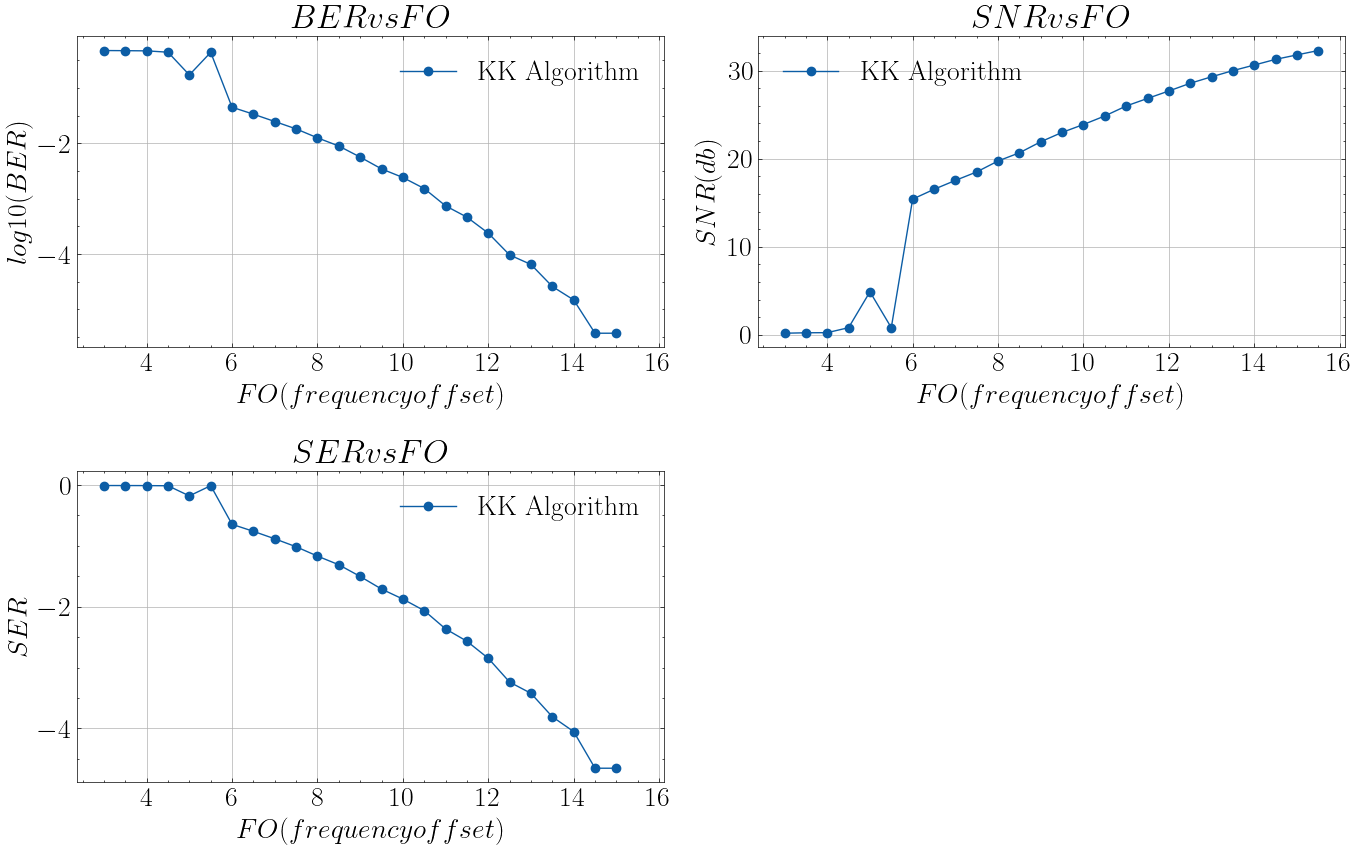

In [8]:
plt.figure(num=None, figsize=(14, 9))

grafico1 = plt.subplot(2, 2, 1)
plt.plot(CSPR, np.log10(BER_KK), '-o', label='KK Algorithm')
plt.xlabel('$FO (frequency offset)$')
plt.ylabel('$log10(BER)$')
plt.grid()
plt.legend()
plt.title('$BER vs FO$')

grafico2 = plt.subplot(2, 2, 2, sharex=grafico1)
plt.plot(CSPR, SNR_KK, '-o', label='KK Algorithm')
plt.xlabel('$FO (frequency offset)$')
plt.ylabel('$SNR(db)$')
plt.grid()
plt.legend()
plt.title('$SNR vs FO$')

grafico3 = plt.subplot(2, 2, 3, sharex=grafico2)
plt.plot(CSPR, np.log10(SER_KK), '-o', label='KK Algorithm')
plt.xlabel('$FO (frequency offset)$')
plt.ylabel('$SER$')
plt.grid()
plt.legend()
plt.title('$SER vs FO$')

plt.tight_layout()

In [6]:
modelNN = tf.keras.models.load_model('Legacy_NN_models/testModel_SpS_'+str(paramADC.SpS_out)+'_FO_2.1GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)))
N = 256 # number of input amplitude samples to the NN

CSPR = np.arange(3, 16, 0.5)

BER_NN = np.zeros(CSPR.size)
SER_NN = np.zeros(CSPR.size)
GMI_NN = np.zeros(CSPR.size)
MI_NN  = np.zeros(CSPR.size)
SNR_NN = np.zeros(CSPR.size)

for indCSPR, CSPR_ in enumerate(CSPR):
   
    # generate optical signal signal
    sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # simulate linear signal propagation
    sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

    # receiver detection and demodulation
    Fc = paramTx.Fc
    Ts = 1 / Fs
    mod = QAMModem(m=paramTx.M)

    freqGrid = paramTx.freqGrid
    print(
        "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
        % (
            chIndex,
            (Fc + freqGrid[chIndex]) / 1e12,
            const.c / (Fc + freqGrid[chIndex]) / 1e-9,
        )
    )

    symbTx = symbTx_[:, :, chIndex]

    Plo_dBm = CSPR_
    Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

    print(
        "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
        % (Plo_dBm, lw / 1e3, FO / 1e6)
    )

    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

    # ### Phase-retrieval stage

    # In[4]:

    # resampling to ADC sampling rate
    sigCh = resample(sigCh, paramADC)
    sfm = resample(sfm, paramADC)
    newFs = paramADC.SpS_out*paramTx.Rs

    # simulate ideal direct-detection optical receiver
    Amp = np.abs(sigRx)
    Amp = resample(Amp, paramADC)

    sfm = sfm/np.sqrt(signal_power(sfm))

    sigPhase = np.angle(sfm)  # get signal phase samples (labels) (L,)
    sigAmp   = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

    # create set of input features
    X_input = np.zeros((len(sigPhase), N))  # (L,N)

    for indPhase in range(len(sigPhase)):
        X_input[indPhase] = sigAmp[indPhase:N+indPhase]

    phiTime_NN = modelNN.predict(X_input)
    phiTime_NN = phiTime_NN.reshape(-1,)

    # optical field reconstruction
    sigRx = np.abs(sfm)*np.exp(1j*phiTime_NN)

    # remove DC level
    sigRx -= np.mean(sigRx)  # np.sqrt(Plo)

    # downshift to baseband
    t = np.arange(0, len(sigRx))*(1/newFs)
    sigRx *= np.exp(-1j * (2 * π * FO * t))

    # correct for (possible) phase ambiguity
    rot = np.mean(sigCh/sigRx)
    sigRx = rot * sigRx
    sigRx = sigRx / np.sqrt(signal_power(sigRx))

    # #### Standard receiver processing

    # In[5]:

    # resample to 2 samples/symbol:
    paramRes = parameters()
    paramRes.Rs = paramTx.Rs
    paramRes.SpS_in = paramADC.SpS_out
    paramRes.SpS_out = 2

    sigRx = resample(sigRx, paramRes)

    # Matched filtering and CD compensation

    # Matched filtering
    if paramTx.pulse == "nrz":
        pulse = pulseShape("nrz", paramADC.SpS_out)
    elif paramTx.pulse == "rrc":
        pulse = pulseShape(
            "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
        )

    pulse = pulse / np.max(np.abs(pulse))
    sigRx = firFilter(pulse, sigRx)

    # plot constellations after matched filtering
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

    # CD compensation
    sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

    #plot constellations after CD compensation
    #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

    # Downsampling to 2 sps and re-synchronization with transmitted sequences
    sigRx = sigRx.reshape(-1, 1)

    symbRx = symbolSync(sigRx, symbTx, 2)

    # In[6]:

    # Power normalization
    x = sigRx
    d = symbRx

    x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
    d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

    # Adaptive equalization
    mod = QAMModem(m=paramTx.M)

    paramEq = parameters()
    paramEq.nTaps = 15
    paramEq.SpS = 2
    paramEq.mu = [5e-3, 2e-3]
    paramEq.numIter = 5
    paramEq.storeCoeff = False
    paramEq.alg = ["nlms", "dd-lms"]
    paramEq.M = paramTx.M
    paramEq.L = [20000, 80000]

    y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

    discard = int(paramEq.L[0]/2)

    #plot constellations after adaptive equalization
    #pconst(y_EQ[discard:-discard, :], lim=True)

    # In[7]:

    # Carrier phase recovery
    paramCPR = parameters()
    paramCPR.alg = "bps"
    paramCPR.M = paramTx.M
    paramCPR.N = 75
    paramCPR.B = 64
    paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

    y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    discard = 5000

    # plot constellations after CPR
    #pconst(y_CPR[discard:-discard, :], lim=True)

    # #### Evaluate transmission metrics

    # In[8]:

    # correct for (possible) phase ambiguity
    for k in range(y_CPR.shape[1]):
        rot = np.mean(d[:, k] / y_CPR[:, k])
        y_CPR[:, k] = rot * y_CPR[:, k]

    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    ind = np.arange(discard, d.shape[0] - discard)
    BER_NN[indCSPR], SER_NN[indCSPR], SNR_NN[indCSPR] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
    GMI_NN[indCSPR], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
    MI_NN[indCSPR] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

    print("Results:\n")
    print("SER: %.2e" % (SER_NN[indCSPR]))
    print("BER: %.2e" % (BER_NN[indCSPR]))
    print("SNR: %.2f dB" % (SNR_NN[indCSPR]))
    print("MI: %.2f bits" % (MI_NN[indCSPR]))
    print("GMI: %.2f bits" % (GMI_NN[indCSPR]))

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 3.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 3.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.067910.
nlms pre-convergence training iteration #1
nlms MSE = 0.051016.
nlms pre-convergence training iteration #2
nlms MSE = 0.050387.
nlms pre-convergence training iteration #3
nlms MSE = 0.050055.
nlms pre-convergence training iteration #4
nlms MSE = 0.049847.


dd-lms - training stage #1
dd-lms MSE = 0.013707.
Results:

SER: 3.79e-01
BER: 8.40e-02
SNR: 12.57 dB
MI: 3.86 bits
GMI: 3.93 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 3.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 3.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.057222.
nlms pre-convergence training iteration #1
nlms MSE = 0.039952.
nlms pre-convergence training iteration #2
nlms MSE = 0.039388.
nlms pre-convergence training iteration #3
nlms MSE = 0.039090.
nlms pre-convergence training iteration #4
nlms MSE = 0.038904.


dd-lms - training stage #1
dd-lms MSE = 0.012682.
Results:

SER: 3.02e-01
BER: 6.44e-02
SNR: 13.87 dB
MI: 4.27 bits
GMI: 4.32 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 4.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 4.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.048567.
nlms pre-convergence training iteration #1
nlms MSE = 0.031175.
nlms pre-convergence training iteration #2
nlms MSE = 0.030667.
nlms pre-convergence training iteration #3
nlms MSE = 0.030401.
nlms pre-convergence training iteration #4
nlms MSE = 0.030236.


dd-lms - training stage #1
dd-lms MSE = 0.011465.
Results:

SER: 2.37e-01
BER: 4.94e-02
SNR: 15.05 dB
MI: 4.59 bits
GMI: 4.62 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 4.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 4.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.041771.
nlms pre-convergence training iteration #1
nlms MSE = 0.024407.
nlms pre-convergence training iteration #2
nlms MSE = 0.023868.
nlms pre-convergence training iteration #3
nlms MSE = 0.023581.
nlms pre-convergence training iteration #4
nlms MSE = 0.023404.


dd-lms - training stage #1
dd-lms MSE = 0.010110.
Results:

SER: 1.78e-01
BER: 3.64e-02
SNR: 16.25 dB
MI: 4.87 bits
GMI: 4.91 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 5.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 5.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036158.
nlms pre-convergence training iteration #1
nlms MSE = 0.018311.
nlms pre-convergence training iteration #2
nlms MSE = 0.017805.
nlms pre-convergence training iteration #3
nlms MSE = 0.017539.
nlms pre-convergence training iteration #4
nlms MSE = 0.017375.


dd-lms - training stage #1
dd-lms MSE = 0.008948.
Results:

SER: 1.33e-01
BER: 2.68e-02
SNR: 17.36 dB
MI: 5.08 bits
GMI: 5.11 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 5.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 5.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.031561.
nlms pre-convergence training iteration #1
nlms MSE = 0.013923.
nlms pre-convergence training iteration #2
nlms MSE = 0.013437.
nlms pre-convergence training iteration #3
nlms MSE = 0.013181.
nlms pre-convergence training iteration #4
nlms MSE = 0.013023.


dd-lms - training stage #1
dd-lms MSE = 0.007715.
Results:

SER: 9.78e-02
BER: 1.91e-02
SNR: 18.69 dB
MI: 5.29 bits
GMI: 5.31 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 6.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 6.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028419.
nlms pre-convergence training iteration #1
nlms MSE = 0.011123.
nlms pre-convergence training iteration #2
nlms MSE = 0.010621.
nlms pre-convergence training iteration #3
nlms MSE = 0.010351.
nlms pre-convergence training iteration #4
nlms MSE = 0.010184.


dd-lms - training stage #1
dd-lms MSE = 0.006535.
Results:

SER: 6.88e-02
BER: 1.33e-02
SNR: 19.85 dB
MI: 5.43 bits
GMI: 5.45 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 6.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 6.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.025703.
nlms pre-convergence training iteration #1
nlms MSE = 0.008289.
nlms pre-convergence training iteration #2
nlms MSE = 0.007793.
nlms pre-convergence training iteration #3
nlms MSE = 0.007525.
nlms pre-convergence training iteration #4
nlms MSE = 0.007359.


dd-lms - training stage #1
dd-lms MSE = 0.005424.
Results:

SER: 4.57e-02
BER: 8.65e-03
SNR: 21.18 dB
MI: 5.56 bits
GMI: 5.57 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 7.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 7.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023830.
nlms pre-convergence training iteration #1
nlms MSE = 0.006550.
nlms pre-convergence training iteration #2
nlms MSE = 0.006060.
nlms pre-convergence training iteration #3
nlms MSE = 0.005797.
nlms pre-convergence training iteration #4
nlms MSE = 0.005634.


dd-lms - training stage #1
dd-lms MSE = 0.004423.
Results:

SER: 3.02e-02
BER: 5.60e-03
SNR: 22.43 dB
MI: 5.68 bits
GMI: 5.68 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 7.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 7.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023020.
nlms pre-convergence training iteration #1
nlms MSE = 0.005461.
nlms pre-convergence training iteration #2
nlms MSE = 0.004975.
nlms pre-convergence training iteration #3
nlms MSE = 0.004712.
nlms pre-convergence training iteration #4
nlms MSE = 0.004550.


dd-lms - training stage #1
dd-lms MSE = 0.003643.
Results:

SER: 1.97e-02
BER: 3.64e-03
SNR: 23.49 dB
MI: 5.73 bits
GMI: 5.73 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 8.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 8.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022772.
nlms pre-convergence training iteration #1
nlms MSE = 0.004794.
nlms pre-convergence training iteration #2
nlms MSE = 0.004307.
nlms pre-convergence training iteration #3
nlms MSE = 0.004043.
nlms pre-convergence training iteration #4
nlms MSE = 0.003879.


dd-lms - training stage #1
dd-lms MSE = 0.002896.
Results:

SER: 1.21e-02
BER: 2.20e-03
SNR: 24.70 dB
MI: 5.81 bits
GMI: 5.81 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 8.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 8.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021283.
nlms pre-convergence training iteration #1
nlms MSE = 0.003820.
nlms pre-convergence training iteration #2
nlms MSE = 0.003321.
nlms pre-convergence training iteration #3
nlms MSE = 0.003052.
nlms pre-convergence training iteration #4
nlms MSE = 0.002886.


dd-lms - training stage #1
dd-lms MSE = 0.002350.
Results:

SER: 7.48e-03
BER: 1.33e-03
SNR: 25.87 dB
MI: 5.87 bits
GMI: 5.87 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 9.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 9.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020962.
nlms pre-convergence training iteration #1
nlms MSE = 0.003165.
nlms pre-convergence training iteration #2
nlms MSE = 0.002688.
nlms pre-convergence training iteration #3
nlms MSE = 0.002429.
nlms pre-convergence training iteration #4
nlms MSE = 0.002267.


dd-lms - training stage #1
dd-lms MSE = 0.001916.
Results:

SER: 4.41e-03
BER: 7.87e-04
SNR: 26.80 dB
MI: 5.91 bits
GMI: 5.91 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 9.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 9.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020853.
nlms pre-convergence training iteration #1
nlms MSE = 0.002983.
nlms pre-convergence training iteration #2
nlms MSE = 0.002495.
nlms pre-convergence training iteration #3
nlms MSE = 0.002232.
nlms pre-convergence training iteration #4
nlms MSE = 0.002070.


dd-lms - training stage #1
dd-lms MSE = 0.001525.
Results:

SER: 2.30e-03
BER: 4.11e-04
SNR: 27.89 dB
MI: 5.95 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 10.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019973.
nlms pre-convergence training iteration #1
nlms MSE = 0.002505.
nlms pre-convergence training iteration #2
nlms MSE = 0.002039.
nlms pre-convergence training iteration #3
nlms MSE = 0.001788.
nlms pre-convergence training iteration #4
nlms MSE = 0.001631.


dd-lms - training stage #1
dd-lms MSE = 0.001236.
Results:

SER: 1.08e-03
BER: 1.94e-04
SNR: 28.89 dB
MI: 5.97 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 10.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020027.
nlms pre-convergence training iteration #1
nlms MSE = 0.002347.
nlms pre-convergence training iteration #2
nlms MSE = 0.001862.
nlms pre-convergence training iteration #3
nlms MSE = 0.001599.
nlms pre-convergence training iteration #4
nlms MSE = 0.001436.


dd-lms - training stage #1
dd-lms MSE = 0.001028.
Results:

SER: 6.67e-04
BER: 1.13e-04
SNR: 29.62 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 11.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 11.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019414.
nlms pre-convergence training iteration #1
nlms MSE = 0.002161.
nlms pre-convergence training iteration #2
nlms MSE = 0.001680.
nlms pre-convergence training iteration #3
nlms MSE = 0.001424.
nlms pre-convergence training iteration #4
nlms MSE = 0.001266.


dd-lms - training stage #1
dd-lms MSE = 0.000881.
Results:

SER: 2.78e-04
BER: 5.00e-05
SNR: 30.32 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 11.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 11.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019726.
nlms pre-convergence training iteration #1
nlms MSE = 0.002114.
nlms pre-convergence training iteration #2
nlms MSE = 0.001626.
nlms pre-convergence training iteration #3
nlms MSE = 0.001362.
nlms pre-convergence training iteration #4
nlms MSE = 0.001199.


dd-lms - training stage #1
dd-lms MSE = 0.000764.
Results:

SER: 1.78e-04
BER: 3.15e-05
SNR: 30.85 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018970.
nlms pre-convergence training iteration #1
nlms MSE = 0.001943.
nlms pre-convergence training iteration #2
nlms MSE = 0.001464.
nlms pre-convergence training iteration #3
nlms MSE = 0.001206.
nlms pre-convergence training iteration #4
nlms MSE = 0.001047.


dd-lms - training stage #1
dd-lms MSE = 0.000685.
Results:

SER: 5.56e-05
BER: 1.11e-05
SNR: 31.42 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019542.
nlms pre-convergence training iteration #1
nlms MSE = 0.002042.
nlms pre-convergence training iteration #2
nlms MSE = 0.001564.
nlms pre-convergence training iteration #3
nlms MSE = 0.001309.
nlms pre-convergence training iteration #4
nlms MSE = 0.001151.


dd-lms - training stage #1
dd-lms MSE = 0.000619.
Results:

SER: 2.22e-05
BER: 3.70e-06
SNR: 31.75 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 13.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 13.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019046.
nlms pre-convergence training iteration #1
nlms MSE = 0.001925.
nlms pre-convergence training iteration #2
nlms MSE = 0.001442.
nlms pre-convergence training iteration #3
nlms MSE = 0.001184.
nlms pre-convergence training iteration #4
nlms MSE = 0.001026.


dd-lms - training stage #1
dd-lms MSE = 0.000581.
Results:

SER: 1.11e-05
BER: 1.85e-06
SNR: 32.03 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 13.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 13.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019485.
nlms pre-convergence training iteration #1
nlms MSE = 0.001901.
nlms pre-convergence training iteration #2
nlms MSE = 0.001426.
nlms pre-convergence training iteration #3
nlms MSE = 0.001172.
nlms pre-convergence training iteration #4
nlms MSE = 0.001015.


dd-lms - training stage #1
dd-lms MSE = 0.000549.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.25 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 14.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 14.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019286.
nlms pre-convergence training iteration #1
nlms MSE = 0.001862.
nlms pre-convergence training iteration #2
nlms MSE = 0.001380.
nlms pre-convergence training iteration #3
nlms MSE = 0.001121.
nlms pre-convergence training iteration #4
nlms MSE = 0.000961.


dd-lms - training stage #1
dd-lms MSE = 0.000539.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.33 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 14.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 14.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019664.
nlms pre-convergence training iteration #1
nlms MSE = 0.002009.
nlms pre-convergence training iteration #2
nlms MSE = 0.001531.
nlms pre-convergence training iteration #3
nlms MSE = 0.001275.
nlms pre-convergence training iteration #4
nlms MSE = 0.001116.


dd-lms - training stage #1
dd-lms MSE = 0.000529.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.38 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 15.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 15.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019668.
nlms pre-convergence training iteration #1
nlms MSE = 0.002006.
nlms pre-convergence training iteration #2
nlms MSE = 0.001535.
nlms pre-convergence training iteration #3
nlms MSE = 0.001280.
nlms pre-convergence training iteration #4
nlms MSE = 0.001122.


dd-lms - training stage #1
dd-lms MSE = 0.000530.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.40 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 15.50 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 15.50 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019634.
nlms pre-convergence training iteration #1
nlms MSE = 0.002074.
nlms pre-convergence training iteration #2
nlms MSE = 0.001583.
nlms pre-convergence training iteration #3
nlms MSE = 0.001319.
nlms pre-convergence training iteration #4
nlms MSE = 0.001156.


dd-lms - training stage #1
dd-lms MSE = 0.000541.
Results:

SER: 0.00e+00
BER: 0.00e+00
SNR: 32.31 dB
MI: 6.00 bits
GMI: 6.00 bits


C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\655506022.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(BER_NN), '-o', label='Rede Neural')
C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\655506022.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(BER_KK), '-x', label='Algoritmo de KK')
C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\655506022.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(SER_NN), '-o', label='Rede Neural')
C:\Users\Silas\AppData\Local\Temp\ipykernel_6564\655506022.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(CSPR, np.log10(SER_KK), '-x', label='Algoritmo de KK')


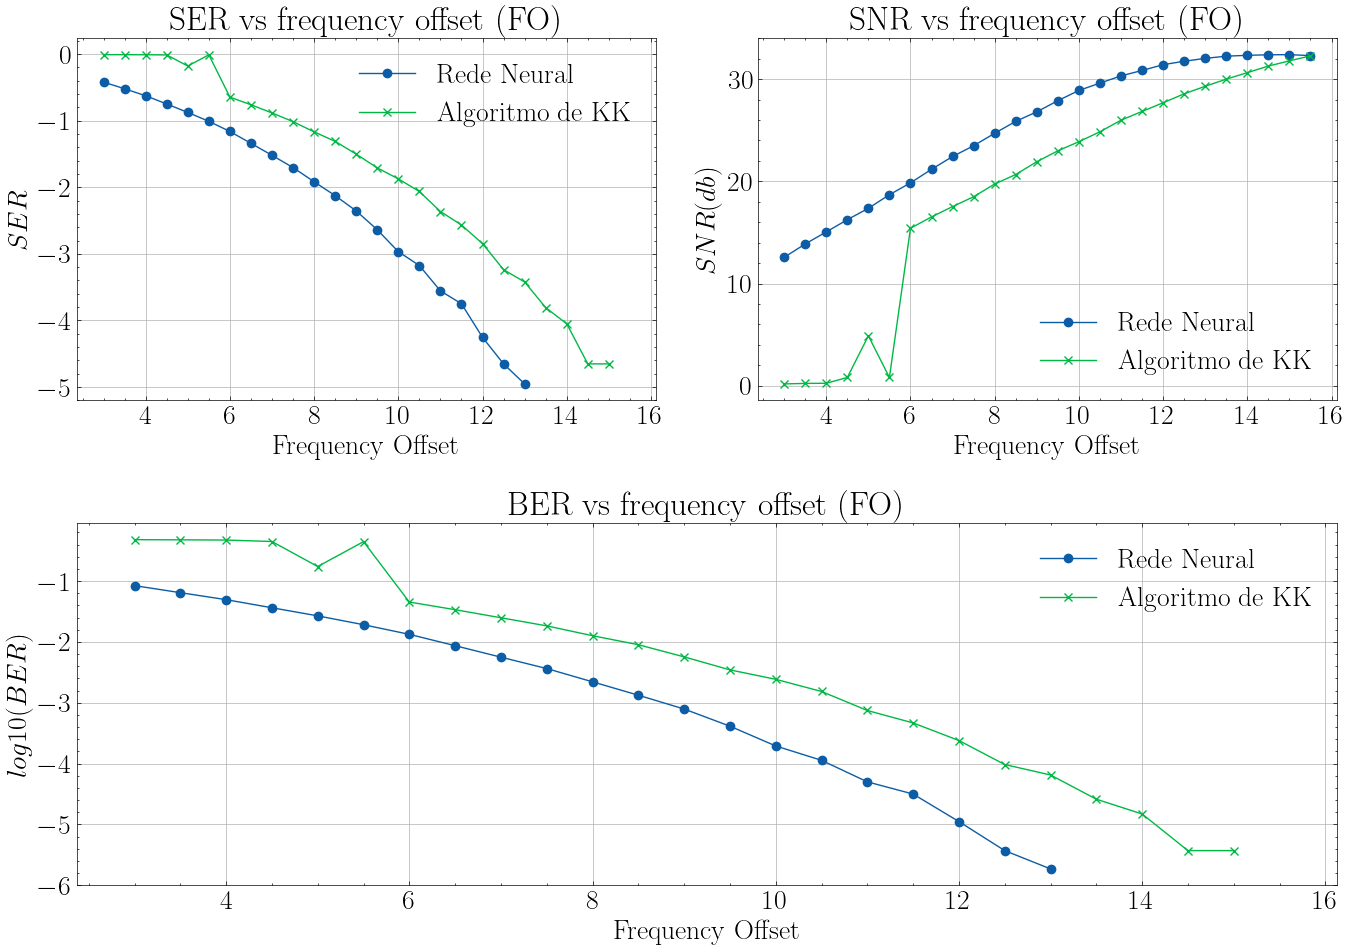

In [9]:
plt.figure(num=None, figsize=(14, 10))

grafico1 = plt.subplot(2, 1, 2)
plt.plot(CSPR, np.log10(BER_NN), '-o', label='Rede Neural')
plt.plot(CSPR, np.log10(BER_KK), '-x', label='Algoritmo de KK')
plt.xlabel('Frequency Offset')
plt.ylabel('$log10(BER)$')
plt.grid()
plt.legend()
plt.title('BER vs frequency offset (FO)')

grafico2 = plt.subplot(2, 2, 2, sharex=grafico1)
plt.plot(CSPR, SNR_NN, '-o', label='Rede Neural')
plt.plot(CSPR, SNR_KK, '-x', label='Algoritmo de KK')
plt.xlabel('Frequency Offset')
plt.ylabel('$SNR(db)$')
plt.grid()
plt.legend()
plt.title('SNR vs frequency offset (FO)')

grafico3 = plt.subplot(2, 2, 1, sharex=grafico2)
plt.plot(CSPR, np.log10(SER_NN), '-o', label='Rede Neural')
plt.plot(CSPR, np.log10(SER_KK), '-x', label='Algoritmo de KK')
plt.xlabel('Frequency Offset')
plt.ylabel('$SER$')
plt.grid()
plt.legend()
plt.title('SER vs frequency offset (FO)')

plt.tight_layout()